# Synthetic Data without interaction: recovery of relevant features

## Make regression dataset

### Data

In [1]:
from pyselect.data import make_regression_with_tensors
from ignite.utils import manual_seed

### Model

In [2]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.data import train_val_test_split
from pyselect.train import ridge_loss, score_function, best_model_callback

Set train, validation and test sizes

In [3]:
train_size = 4000
val_size = 1000
test_size = 1000

Data properties

In [4]:
n_features = 500
n_informative = 10

In [5]:
manual_seed(0)
X_mr, y_mr, coef_mr = make_regression_with_tensors(n_samples=6000, n_features=n_features, n_informative=n_informative)

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_mr, y_mr, train_size, val_size, test_size)

Generate datasets

In [7]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)

Dataloaders

In [8]:
train_loader = DataLoader(train, batch_size=500)
val_loader = DataLoader(val, batch_size=500)
test_loader = DataLoader(test, batch_size=500)

Objective for optuna

In [9]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    in_features = n_features
    out_features = 600
    model = RandomFourierFeaturesNet(in_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-4, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 200
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initialize optuna study

In [10]:
tpe_sampler = TPESampler(seed=0)

In [11]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-22 14:26:59,159] A new study created in memory with name: no-name-f787312b-8556-40e6-a2ec-c02b555dcbaa


In [12]:
n_epochs = 1001

In [13]:
study.optimize(objective, n_trials=20, callbacks=[best_model_callback])

Training - Epoch: 200 Loss: 1.26893
Validation - Epoch: 200 Loss: 1.26185
Learning rate: 0.0125
Training - Epoch: 400 Loss: 1.05057
Validation - Epoch: 400 Loss: 1.06668
Learning rate: 0.0125
Training - Epoch: 600 Loss: 1.00027
Validation - Epoch: 600 Loss: 1.04710
Learning rate: 0.0063
Training - Epoch: 800 Loss: 0.97837
Validation - Epoch: 800 Loss: 1.04647
Learning rate: 0.0063


[I 2022-02-22 14:27:28,471] Trial 0 finished with value: 1.05027783203125 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 1.3981961408994034e-05}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 0.96038
Validation - Epoch: 1000 Loss: 1.05000
Learning rate: 0.0063
Training - Epoch: 200 Loss: 1.17911
Validation - Epoch: 200 Loss: 1.20395
Learning rate: 0.0161
Training - Epoch: 400 Loss: 1.01432
Validation - Epoch: 400 Loss: 1.07611
Learning rate: 0.0161
Training - Epoch: 600 Loss: 0.96716
Validation - Epoch: 600 Loss: 1.06294
Learning rate: 0.0080
Training - Epoch: 800 Loss: 0.94517
Validation - Epoch: 800 Loss: 1.06446
Learning rate: 0.0080


[I 2022-02-22 14:27:55,003] Trial 1 finished with value: 1.0696114501953125 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 4.311710058685494e-06}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 0.92661
Validation - Epoch: 1000 Loss: 1.06938
Learning rate: 0.0080
Training - Epoch: 200 Loss: 1.56993
Validation - Epoch: 200 Loss: 1.55552
Learning rate: 0.0070
Training - Epoch: 400 Loss: 1.23145
Validation - Epoch: 400 Loss: 1.22998
Learning rate: 0.0070
Training - Epoch: 600 Loss: 1.12701
Validation - Epoch: 600 Loss: 1.13465
Learning rate: 0.0035
Training - Epoch: 800 Loss: 1.07993
Validation - Epoch: 800 Loss: 1.09602
Learning rate: 0.0035


[I 2022-02-22 14:28:21,773] Trial 2 finished with value: 1.072363525390625 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 8.66327976135455e-06}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 1.04579
Validation - Epoch: 1000 Loss: 1.07233
Learning rate: 0.0035
Training - Epoch: 200 Loss: 1.56046
Validation - Epoch: 200 Loss: 1.57688
Learning rate: 0.0075
Training - Epoch: 400 Loss: 1.17845
Validation - Epoch: 400 Loss: 1.18986
Learning rate: 0.0075
Training - Epoch: 600 Loss: 1.08621
Validation - Epoch: 600 Loss: 1.10852
Learning rate: 0.0038
Training - Epoch: 800 Loss: 1.05084
Validation - Epoch: 800 Loss: 1.08265
Learning rate: 0.0038


[I 2022-02-22 14:28:49,388] Trial 3 finished with value: 1.06783349609375 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 4.7349893044994796e-05}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 1.02547
Validation - Epoch: 1000 Loss: 1.06773
Learning rate: 0.0038
Training - Epoch: 200 Loss: 0.90164
Validation - Epoch: 200 Loss: 1.16533
Learning rate: 0.0846
Training - Epoch: 400 Loss: 0.79978
Validation - Epoch: 400 Loss: 1.25589
Learning rate: 0.0846
Training - Epoch: 600 Loss: 0.74486
Validation - Epoch: 600 Loss: 1.31114
Learning rate: 0.0423
Training - Epoch: 800 Loss: 0.72027
Validation - Epoch: 800 Loss: 1.35132
Learning rate: 0.0423


[I 2022-02-22 14:29:16,990] Trial 4 finished with value: 1.385610107421875 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 1.4135935551752292e-06}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 0.70023
Validation - Epoch: 1000 Loss: 1.38756
Learning rate: 0.0423
Training - Epoch: 200 Loss: 1.00013
Validation - Epoch: 200 Loss: 1.07789
Learning rate: 0.0383
Training - Epoch: 400 Loss: 0.90008
Validation - Epoch: 400 Loss: 1.08982
Learning rate: 0.0383
Training - Epoch: 600 Loss: 0.85216
Validation - Epoch: 600 Loss: 1.11194
Learning rate: 0.0192
Training - Epoch: 800 Loss: 0.82679
Validation - Epoch: 800 Loss: 1.12619
Learning rate: 0.0192


Engine run is terminating due to exception: Trial was pruned at 1000 epoch.
Engine run is terminating due to exception: Trial was pruned at 1000 epoch.
[I 2022-02-22 14:29:44,007] Trial 5 pruned. Trial was pruned at 1000 epoch.


Training - Epoch: 1000 Loss: 0.80466
Training - Epoch: 200 Loss: 1.24075
Validation - Epoch: 200 Loss: 1.24440
Learning rate: 0.0137
Training - Epoch: 400 Loss: 1.04229
Validation - Epoch: 400 Loss: 1.06775
Learning rate: 0.0137
Training - Epoch: 600 Loss: 0.99261
Validation - Epoch: 600 Loss: 1.05193
Learning rate: 0.0068
Training - Epoch: 800 Loss: 0.97043
Validation - Epoch: 800 Loss: 1.05423
Learning rate: 0.0068


[I 2022-02-22 14:30:10,721] Trial 6 finished with value: 1.0602027587890626 and parameters: {'learning_rate': 0.013680095279726922, 'reg_param': 5.9812219011525586e-05}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 0.95199
Validation - Epoch: 1000 Loss: 1.06014
Learning rate: 0.0068


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:30:16,739] Trial 7 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 3.47957


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:30:22,627] Trial 8 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 3.55595
Training - Epoch: 200 Loss: 0.98879
Validation - Epoch: 200 Loss: 1.04586
Learning rate: 0.0360
Training - Epoch: 400 Loss: 0.90655
Validation - Epoch: 400 Loss: 1.08096
Learning rate: 0.0360
Training - Epoch: 600 Loss: 0.86567
Validation - Epoch: 600 Loss: 1.11559
Learning rate: 0.0180
Training - Epoch: 800 Loss: 0.84406
Validation - Epoch: 800 Loss: 1.14072
Learning rate: 0.0180


[I 2022-02-22 14:30:51,087] Trial 9 finished with value: 1.166205810546875 and parameters: {'learning_rate': 0.0360009119291161, 'reg_param': 4.074144654166234e-05}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 0.82501
Validation - Epoch: 1000 Loss: 1.16624
Learning rate: 0.0180


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:30:56,928] Trial 10 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.91527
Training - Epoch: 200 Loss: 1.11317
Validation - Epoch: 200 Loss: 1.13156
Learning rate: 0.0181
Training - Epoch: 400 Loss: 0.98050
Validation - Epoch: 400 Loss: 1.06345
Learning rate: 0.0181
Training - Epoch: 600 Loss: 0.93830
Validation - Epoch: 600 Loss: 1.06815
Learning rate: 0.0091
Training - Epoch: 800 Loss: 0.91774
Validation - Epoch: 800 Loss: 1.07570
Learning rate: 0.0091


[I 2022-02-22 14:31:25,346] Trial 11 finished with value: 1.0844205322265625 and parameters: {'learning_rate': 0.018121171769705097, 'reg_param': 1.471439694924402e-05}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 0.90032
Validation - Epoch: 1000 Loss: 1.08423
Learning rate: 0.0091


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:31:30,780] Trial 12 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 2.20407


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:31:36,508] Trial 13 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.24230
Training - Epoch: 200 Loss: 1.01634
Validation - Epoch: 200 Loss: 1.06521
Learning rate: 0.0355
Training - Epoch: 400 Loss: 0.92215
Validation - Epoch: 400 Loss: 1.07798
Learning rate: 0.0355
Training - Epoch: 600 Loss: 0.88049
Validation - Epoch: 600 Loss: 1.11316
Learning rate: 0.0178
Training - Epoch: 800 Loss: 0.85821
Validation - Epoch: 800 Loss: 1.13723
Learning rate: 0.0178


[I 2022-02-22 14:32:04,811] Trial 14 finished with value: 1.1600986328125 and parameters: {'learning_rate': 0.035530565708166886, 'reg_param': 9.588654115413726e-05}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 0.83879
Validation - Epoch: 1000 Loss: 1.16027
Learning rate: 0.0178


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:32:10,303] Trial 15 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 2.34922


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:32:15,765] Trial 16 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.32785


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:32:21,208] Trial 17 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.84347
Training - Epoch: 200 Loss: 1.04206
Validation - Epoch: 200 Loss: 1.07532
Learning rate: 0.0236
Training - Epoch: 400 Loss: 0.94293
Validation - Epoch: 400 Loss: 1.05049
Learning rate: 0.0236
Training - Epoch: 600 Loss: 0.90437
Validation - Epoch: 600 Loss: 1.05878
Learning rate: 0.0118
Training - Epoch: 800 Loss: 0.88444
Validation - Epoch: 800 Loss: 1.06792
Learning rate: 0.0118


[I 2022-02-22 14:32:49,183] Trial 18 finished with value: 1.0784671630859375 and parameters: {'learning_rate': 0.02363677924260067, 'reg_param': 6.982201163491984e-06}. Best is trial 0 with value: 1.05027783203125.


Training - Epoch: 1000 Loss: 0.86705
Validation - Epoch: 1000 Loss: 1.07837
Learning rate: 0.0118
Training - Epoch: 200 Loss: 0.94210
Validation - Epoch: 200 Loss: 1.08677
Learning rate: 0.0613


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-22 14:32:59,383] Trial 19 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 0.85648


Get best model

In [14]:
best_model = study.user_attrs['best_model']

In [15]:
torch.save(best_model.state_dict(), '../models/make-regression.pth')

Replicate best model on different test datasets

In [16]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number + 1000
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test, _ = make_regression_with_tensors(n_samples=test_size, n_features=n_features,
                                                  n_informative=n_informative)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [17]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-22 14:32:59,417] A new study created in memory with name: no-name-247936e8-fd0e-417c-b252-2ea0e347a9bf


In [18]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-22 14:32:59,436] Trial 0 finished with value: 2.7705770460264683 and parameters: {}. Best is trial 0 with value: 2.7705770460264683.
[I 2022-02-22 14:32:59,450] Trial 1 finished with value: 3.270748671940417 and parameters: {}. Best is trial 0 with value: 2.7705770460264683.
[I 2022-02-22 14:32:59,464] Trial 2 finished with value: 3.88097799972829 and parameters: {}. Best is trial 0 with value: 2.7705770460264683.
[I 2022-02-22 14:32:59,478] Trial 3 finished with value: 3.4006377216725836 and parameters: {}. Best is trial 0 with value: 2.7705770460264683.
[I 2022-02-22 14:32:59,492] Trial 4 finished with value: 3.9338946787820848 and parameters: {}. Best is trial 0 with value: 2.7705770460264683.
[I 2022-02-22 14:32:59,506] Trial 5 finished with value: 2.592973340045651 and parameters: {}. Best is trial 5 with value: 2.592973340045651.
[I 2022-02-22 14:32:59,520] Trial 6 finished with value: 3.435444129539513 and parameters: {}. Best is trial 5 with value: 2.592973340045651.

In [19]:
replication.trials_dataframe()['value'].mean()

3.4547675236289126

In [20]:
replication.trials_dataframe()['value'].std()

0.45109693321266975

### Visualization

#### Bands

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
bands = best_model.rff_net[0].bandwidths.to('cpu').detach().numpy()

In [23]:
inf_features = (np.abs(coef_mr) >= 1e-3).ravel()

In [24]:
inf_bands = bands[inf_features]
noninf_bands = bands[~inf_features]

In [25]:
lim = np.abs(bands).max()
bins = np.linspace(-lim * 1.1, lim * 1.1, 40)

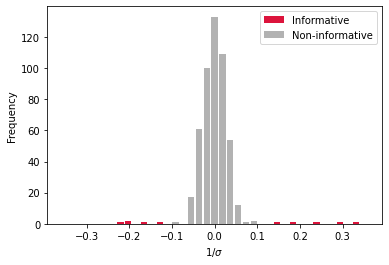

In [26]:
fig = plt.figure()
plt.hist(inf_bands, bins=bins, rwidth=0.8, color="crimson", label="Informative")
plt.hist(
    noninf_bands,
    bins=bins,
    rwidth=0.8,
    color="black",
    alpha=0.3,
    label="Non-informative",
)
plt.xlabel(r"1/$\sigma$")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.show()

In [27]:
index = np.array(list(range(0, n_features)))
inf_index = index[inf_features]
noninf_index = index[~inf_features]

In [28]:
inf_index

array([ 15,  90, 153, 159, 254, 283, 316, 445, 461, 489])

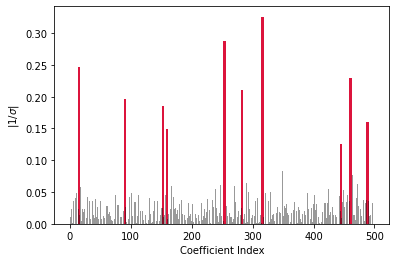

In [29]:
fig = plt.figure()
plt.bar(
    inf_index,
    np.abs(bands[inf_features]),
    color="crimson",
    width=4,
    label="Informative",
)
plt.bar(
    noninf_index,
    np.abs(bands[~inf_features]),
    color="black",
    alpha=0.4,
    label="Non-informative",
)
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
plt.show()

In [30]:
model_linear_weights = best_model.rff_net[2].weight.to('cpu').detach().numpy().ravel()

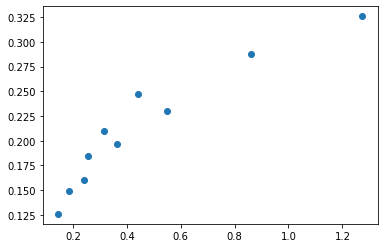

In [31]:
plt.plot(np.abs(coef_mr[inf_features]), np.abs(bands[inf_features]), 'o')
plt.show()